<h1 align="center">Sentiment Analysis on Movie Reviews 🎬</h1>
<h3>Name : Phan Vinh Phu</h3>

-------------------------------------------------------------------------------------

### TABLE OF CONTENTS

### [Introduction](#chapter_1)

### [1. Set Up](#chapter_2)
- [1.1 Install & Import Dependencies](#chapter_2_1)
- [1.2 Download the IMDB dataset](#chapter_2_2)

### [2. Data Exploration](#chapter_3)

### [3. Model Comparison](#chapter_4)
- [3.1 Model 1 - OrigNN](#chapter_4_1)
- [3.2 Model 2 - Sratch](#chapter_4_2)
- [3.3 Model 3 - DenseNNi](#chapter_4_3)
- [3.4 Model 4 - DenseNNii](#chapter_4_4)
- [3.5 Model 5 - DenseNNiii](#chapter_4_5)
- [3.6 Model 6 - DropNNi](#chapter_4_6)
- [3.7 Model 7 - DropNNii](#chapter_4_7)

### [4. Best Model & Sentiment Prediction](#chapter_5)
- [4.1 Clone the Sratch Model](#chapter_5_1)
- [4.2 Predict the test set](#chapter_5_2)
- [4.3 Top most 5 positive reviews](#chapter_5_3)
- [4.4 Top most 5 negative reviews](#chapter_5_4)
- [4.5 The best model with Dropout layer](#chapter_5_5)   
- [4.6 Comment](#chapter_5_6)   

### [5. Conclusion](#chapter_6)


------------------------------------------------------------------------

## Introduction
<a class="anchor" id="chapter_1"></a>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary* or two-class classification.

This project use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

## 1. Setup
<a class="anchor" id="chapter_2"></a>

### 1.1 Install & Import Dependencies <a class="anchor" id="chapter_2_1"></a>

In [ ]:
# Import the libraries
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import losses

import matplotlib.pyplot as plt
import re
import string

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


### 1.2 Download the IMDB dataset <a class="anchor" id="chapter_2_2"></a>


In [ ]:
# Load the train, test dataset
train_data, test_data = tfds.load(name = "imdb_reviews",
                                  split=["train", "test"],
                                  batch_size=-1,
                                  as_supervised = True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXTT3Y2/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXTT3Y2/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXTT3Y2/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## 2. Data Exploration<a class="anchor" id="chapter_3"></a>
Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [ ]:
# Display the length of train , test dataset
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


Let's print first 10 examples.

In [ ]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

Let's also print the first 10 labels.

In [ ]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## 3. Model Comparison <a class="anchor" id="chapter_4"></a>

This section involves building and evaluating multiple model architectures to determine the most effective one for the task.

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

### 3.1 Model 1 - OrigNN
<a class="anchor" id="chapter_4_1"></a>

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.

In [ ]:
# The Keras layer that uses a TensorFlow Hub model to embed the sentences
OrigNN = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(OrigNN, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423194 , -0.01190171,  0.06337537,  0.0686297 , -0.16776839,
        -0.10581177,  0.168653  , -0.04998823, -0.31148052,  0.07910344,
         0.15442258,  0.01488661,  0.03930155,  0.19772716, -0.12215477,
        -0.04120982, -0.27041087, -0.21922147,  0.26517656, -0.80739075,
         0.25833526, -0.31004202,  0.2868321 ,  0.19433866, -0.29036498,
         0.0386285 , -0.78444123, -0.04793238,  0.41102988, -0.36388886,
        -0.58034706,  0.30269453,  0.36308962, -0.15227163, -0.4439151 ,
         0.19462997,  0.19528405,  0.05666233,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201319 , -0.04418665, -0.08550781,
        -0.55847436, -0.2333639 , -0.20782956, -0.03543065, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862677,  0.7753425 , -0.07667087,
        -0.15752274,  0.01872334, -0.08169781, -0.3521876 ,  0.46373403,
        -0.08492758,  0.07166861, -0.00670818,  0.12686071, -0.19326551,
 

In [ ]:
# Origin model using pretrained embeddings
OrigNN = tf.keras.Sequential()
OrigNN.add(hub_layer)
OrigNN.add(tf.keras.layers.Dense(16, activation='relu'))
OrigNN.add(tf.keras.layers.Dense(1))

OrigNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:
<ol>
<li>The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using (<a href="https://tfhub.dev/google/nnlm-en-dim50/2">google/nnlm-en-dim50/2</a>) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: <code translate="no" dir="ltr">(num_examples, embedding_dimension)</code>.</li>
<li>This fixed-length output vector is piped through a fully-connected (<code translate="no" dir="ltr">Dense</code>) layer with 16 hidden units.</li>
<li>The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.</li>
</ol>


#### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

#### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function.

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [ ]:
# Compile the origin model
OrigNN.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

#### Create a validation set for Origin model

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [ ]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#### Train the Origin model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [ ]:
OrigNN_history = OrigNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 13s 234ms/step - loss: 0.6454 - accuracy: 0.6553 - val_loss: 0.5945 - val_accuracy: 0.7383
Epoch 2/40
30/30 [==============================] - 8s 266ms/step - loss: 0.5311 - accuracy: 0.7854 - val_loss: 0.4897 - val_accuracy: 0.7996
Epoch 3/40
30/30 [==============================] - 7s 220ms/step - loss: 0.4010 - accuracy: 0.8588 - val_loss: 0.3955 - val_accuracy: 0.8422
Epoch 4/40
30/30 [==============================] - 8s 262ms/step - loss: 0.2931 - accuracy: 0.9022 - val_loss: 0.3424 - val_accuracy: 0.8574
Epoch 5/40
30/30 [==============================] - 7s 226ms/step - loss: 0.2166 - accuracy: 0.9307 - val_loss: 0.3168 - val_accuracy: 0.8670
Epoch 6/40
30/30 [==============================] - 8s 261ms/step - loss: 0.1615 - accuracy: 0.9530 - val_loss: 0.3053 - val_accuracy: 0.8696
Epoch 7/40
30/30 [==============================] - 7s 248ms/step - loss: 0.1193 - accuracy: 0.9697 - val_loss: 0.3054 - val_accuracy: 0.8735
Epoch

#### Evaluate the Origin model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
OrigNN_results = OrigNN.evaluate(test_examples, test_labels)

print(OrigNN_results)

782/782 [==============================] - 4s 5ms/step - loss: 0.6188 - accuracy: 0.8473
[0.618827760219574, 0.8472800254821777]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

#### Create a graph of accuracy and loss over time - Origin model

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
OrigNN_history_dict = OrigNN_history.history
OrigNN_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

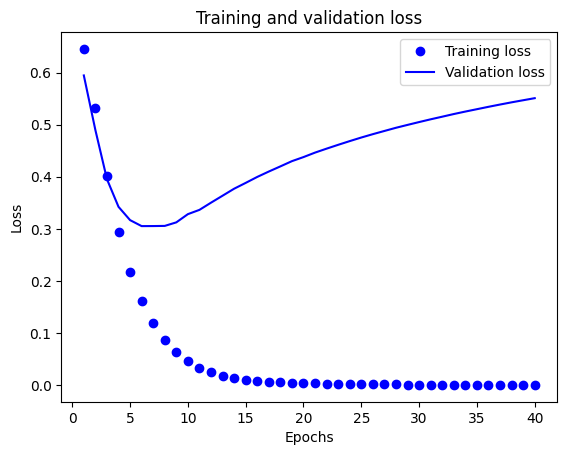

In [ ]:
acc = OrigNN_history_dict['accuracy']
val_acc = OrigNN_history_dict['val_accuracy']
loss = OrigNN_history_dict['loss']
val_loss = OrigNN_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

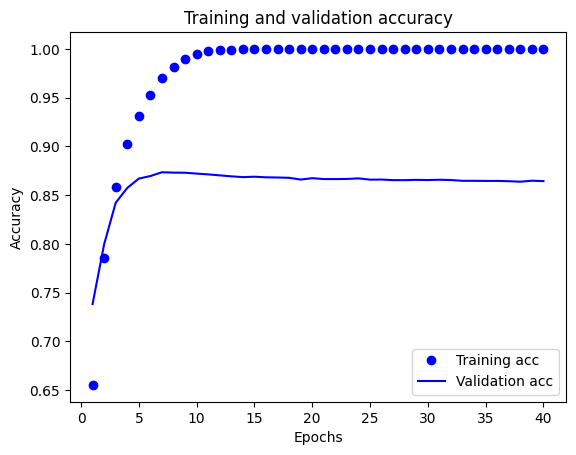

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

### 3.2 Model 2 - Sratch model
<a class="anchor" id="chapter_4_2"></a>

In this part, I reuse the Orgin model but remove the Dropout layers and add one Dense layer of size 16.  Call this modified model ScratchNN.  Then, compare the performance of ScratchNN with OrigNN, just considering the final validation and test accuracies.

##### Build the Sratch model

Now , I will standardize, tokenize, and vectorize the data using the helpful <code translate="no" dir="ltr">tf.keras.layers.TextVectorization</code> layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

<p>As you saw above, the reviews contain various HTML tags like <code translate="no" dir="ltr">&lt;br /&gt;</code>. These tags will not be removed by the default standardizer in the <code translate="no" dir="ltr">TextVectorization</code> layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). I will write a custom standardization function to remove the HTML.</p>

In [ ]:
# Function for preprocessing text data
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, I will create a <code translate="no" dir="ltr">TextVectorization</code> layer. I will use this layer to standardize, tokenize, and vectorize our data. I set the output_mode to int to create unique integer indices for each token.

<p>Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum <code translate="no" dir="ltr">sequence_length</code>, which will cause the layer to pad or truncate sequences to exactly <code translate="no" dir="ltr">sequence_length</code> values.</p>

In [ ]:
max_features = 100000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
vectorize_layer.adapt(train_examples)

Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
# function to see the result
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
first_review, first_label = train_examples[0], train_labels[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label 0
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   11,    13,    33,   414,   380,    17,    89,    26, 10552,
            8,    32,  1336,  3544,    41,   489, 11365,   190,    23,
           84,   151,    18,    11,   219,   318,    26,    64,

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [ ]:
print("1336 ---> ",vectorize_layer.get_vocabulary()[1336])
print(" 489 ---> ",vectorize_layer.get_vocabulary()[489])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1336 --->  christopher
 489 --->  michael
Vocabulary size: 100000


It's time to create the neural network:

In [ ]:
embedding_dim = 50
SratchNN = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(max_features, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)])

SratchNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 50)           5000000   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,000,833
Trainable params: 5,000,833
No

The layers are stacked sequentially to build the classifier:

<ol>
<li>The first layer is an <code translate="no" dir="ltr">Embedding</code> layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: <code translate="no" dir="ltr">(batch, sequence, embedding)</code>.  To learn more about embeddings, check out the <a href="https://www.tensorflow.org/text/guide/word_embeddings">Word embeddings</a> tutorial.</li>
<li>Next, a <code translate="no" dir="ltr">GlobalAveragePooling1D</code> layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.</li>
<li>The fixed-length output vector is piped through a fully-connected (<code translate="no" dir="ltr">Dense</code>) layer with 16 hidden units.</li>
<li>The last layer is densely connected with a single output node.</li>
</ol>

##### Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use <code translate="no" dir="ltr">losses.BinaryCrossentropy</code> loss function.

Now, configure the model to use an optimizer and a loss function:

In [ ]:
SratchNN.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

##### Train the Sratch Model

In [ ]:
SratchNN_history = SratchNN.fit(
    partial_x_train,
    partial_y_train,
    validation_data=(x_val,y_val),
    epochs=40,
    batch_size = 512,
    verbose=1
    )

Epoch 1/40
30/30 [==============================] - 9s 257ms/step - loss: 0.6914 - accuracy: 0.6162 - val_loss: 0.6881 - val_accuracy: 0.6943
Epoch 2/40
30/30 [==============================] - 8s 265ms/step - loss: 0.6823 - accuracy: 0.7307 - val_loss: 0.6746 - val_accuracy: 0.7425
Epoch 3/40
30/30 [==============================] - 7s 222ms/step - loss: 0.6606 - accuracy: 0.7673 - val_loss: 0.6458 - val_accuracy: 0.7719
Epoch 4/40
30/30 [==============================] - 7s 241ms/step - loss: 0.6195 - accuracy: 0.7971 - val_loss: 0.5996 - val_accuracy: 0.7880
Epoch 5/40
30/30 [==============================] - 7s 233ms/step - loss: 0.5593 - accuracy: 0.8224 - val_loss: 0.5402 - val_accuracy: 0.8127
Epoch 6/40
30/30 [==============================] - 7s 229ms/step - loss: 0.4887 - accuracy: 0.8487 - val_loss: 0.4809 - val_accuracy: 0.8284
Epoch 7/40
30/30 [==============================] - 7s 241ms/step - loss: 0.4206 - accuracy: 0.8685 - val_loss: 0.4322 - val_accuracy: 0.8418
Epoch 

##### Evaluate the Scratch model

In [ ]:
SratchNN_results = SratchNN.evaluate(test_examples, test_labels)

print(OrigNN_results)
print(SratchNN_results)

782/782 [==============================] - 4s 5ms/step - loss: 0.4293 - accuracy: 0.8554
[0.618827760219574, 0.8472800254821777]
[0.4293387234210968, 0.8554400205612183]


##### Graph of accuracy and loss over time

model.fit() returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
OrigNN_history_dict = OrigNN_history.history
SratchNN_history_dict = SratchNN_history.history

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

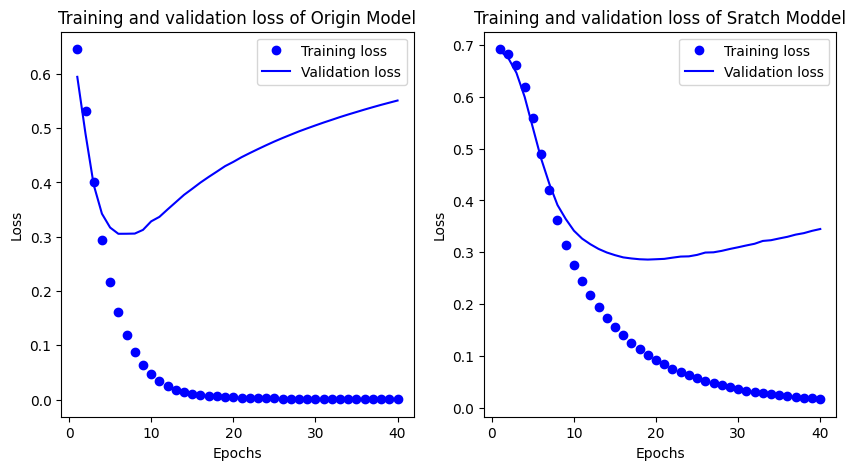

In [ ]:
# Origin Model
OriginNN_acc = OrigNN_history_dict['accuracy']
OriginNN_val_acc = OrigNN_history_dict['val_accuracy']
OriginNN_loss = OrigNN_history_dict['loss']
OriginNN_val_loss = OrigNN_history_dict['val_loss']

# Sratch Model
SratchNN_acc = SratchNN_history_dict['accuracy']
SratchNN_val_acc = SratchNN_history_dict['val_accuracy']
SratchNN_loss = SratchNN_history_dict['loss']
SratchNN_val_loss = SratchNN_history_dict['val_loss']

epochs = range(1, len(OriginNN_acc) + 1)

fig, ((ax1, ax2)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

# plot for Origin Model
# "bo" is for "blue dot"
ax1.plot(epochs, OriginNN_loss, 'bo', label='Training loss')
# b is for "solid blue line"
ax1.plot(epochs, OriginNN_val_loss, 'b', label='Validation loss')
ax1.title.set_text('Training and validation loss of Origin Model')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for Sratch Model
ax2.plot(epochs, SratchNN_loss, 'bo', label='Training loss')
ax2.plot(epochs, SratchNN_val_loss, 'b', label='Validation loss')
ax2.title.set_text('Training and validation loss of Sratch Moddel')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

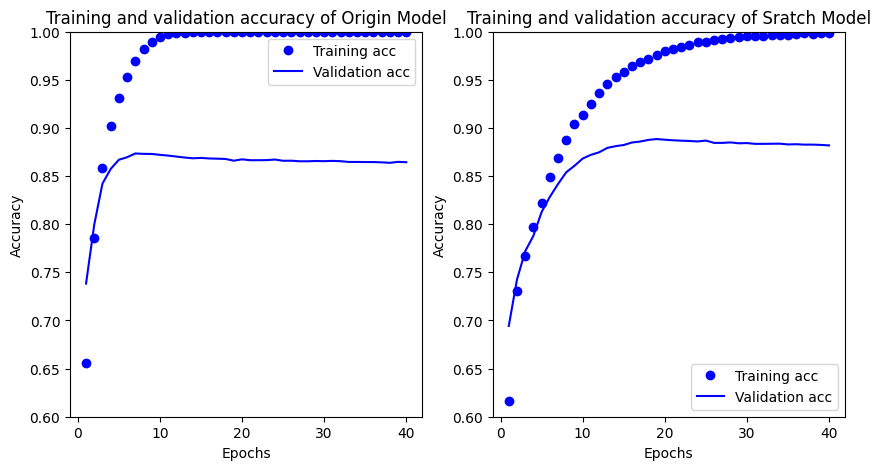

In [ ]:
fig, ((ax3, ax4)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

ax3.plot(epochs, OriginNN_acc, 'bo', label='Training acc')
ax3.plot(epochs, OriginNN_val_acc, 'b', label='Validation acc')
ax3.set_title('Training and validation accuracy of Origin Model')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.set_ylim(0.60, 1.00)
ax3.legend()

ax4.plot(epochs, SratchNN_acc, 'bo', label='Training acc')
ax4.plot(epochs, SratchNN_val_acc, 'b', label='Validation acc')
ax4.set_title('Training and validation accuracy of Sratch Model')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')
ax4.set_ylim(0.60, 1.00)
ax4.legend()

plt.show()

##### Comment

- **The trainning and validation loss graphs** shows that there is **the overfitting problem** which occurs with pretrained embeddings model. While the training loss goes down over time, the validation loss goes down until a turning point is found, and there it starts going up again. That point represents the beginning of overfitting. Sratch model has this problem but **the gap between trainning loss and validation is not as big as pretrained embeddings model.**

<br>

- Regards of the accuracy when predicting test dataset, **the accuracy of Origin model** is `84.56%` and that of **Sratch model** is `84.92%`. It can be concluded that there is no clear difference between two model's test accuracy. The reason for this might be that the **Sratch model** with embeddings defined from scratch allows for adaptation to the specific training data and can perform well when there is sufficient labeled data available.

<br>

In summary, the model with pretrained embeddings benefits from prelearned semantic representations, which can be useful when the pretrained embeddings align well with the target task or when data is limited.
<br>On the other hand, the model with embeddings from scratch allows for adaptation to the specific training data and can perform well when there is sufficient labeled data available.

### 3.3 Model 3 - DenseNNi
<a class="anchor" id="chapter_4_3"></a>

For this task, I'll revert to OrigNN as the starting point.  Change the Dense hidden layer in the neural net from 16 neurons to (50 + 10 * 9) neurons.  Call this network DenseNNi.  I'll train and evaluate this model and plot the graphs.Then, I compare the performance of DenseNNi with OrigNN.

#### Build the DenseNNi model

In [ ]:
N=9

DenseNNi=tf.keras.Sequential()
DenseNNi.add(hub_layer)
DenseNNi.add(tf.keras.layers.Dense(50 + 10 * N, activation='relu'))
DenseNNi.add(tf.keras.layers.Dense(1))

DenseNNi.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 140)               7140      
                                                                 
 dense_5 (Dense)             (None, 1)                 141       
                                                                 
Total params: 48,197,881
Trainable params: 48,197,881
Non-trainable params: 0
_________________________________________________________________


#### Loss function and optimizer

In [ ]:
DenseNNi.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

#### Train the DenseNNi model

In [ ]:
# DenseNNi model
DenseNNi_history = DenseNNi.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 7s 183ms/step - loss: 0.4597 - accuracy: 0.9094 - val_loss: 0.3745 - val_accuracy: 0.8644
Epoch 2/40
30/30 [==============================] - 7s 228ms/step - loss: 0.1364 - accuracy: 0.9981 - val_loss: 0.3064 - val_accuracy: 0.8719
Epoch 3/40
30/30 [==============================] - 6s 209ms/step - loss: 0.0494 - accuracy: 0.9995 - val_loss: 0.3184 - val_accuracy: 0.8741
Epoch 4/40
30/30 [==============================] - 7s 226ms/step - loss: 0.0236 - accuracy: 0.9999 - val_loss: 0.3432 - val_accuracy: 0.8723
Epoch 5/40
30/30 [==============================] - 5s 176ms/step - loss: 0.0135 - accuracy: 0.9999 - val_loss: 0.3672 - val_accuracy: 0.8711
Epoch 6/40
30/30 [==============================] - 6s 217ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.3896 - val_accuracy: 0.8712
Epoch 7/40
30/30 [==============================] - 5s 152ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.4119 - val_accuracy: 0.8692
Epoch 

#### Evaluate the DenseNNi model

In [ ]:
DenseNNi_results = DenseNNi.evaluate(test_examples, test_labels)

print(DenseNNi_results)

782/782 [==============================] - 4s 5ms/step - loss: 0.8081 - accuracy: 0.8470
[0.8081465363502502, 0.847000002861023]


#### Graph of accuracy and loss over time

model.fit() returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
DenseNNi_history_dict = DenseNNi_history.history

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

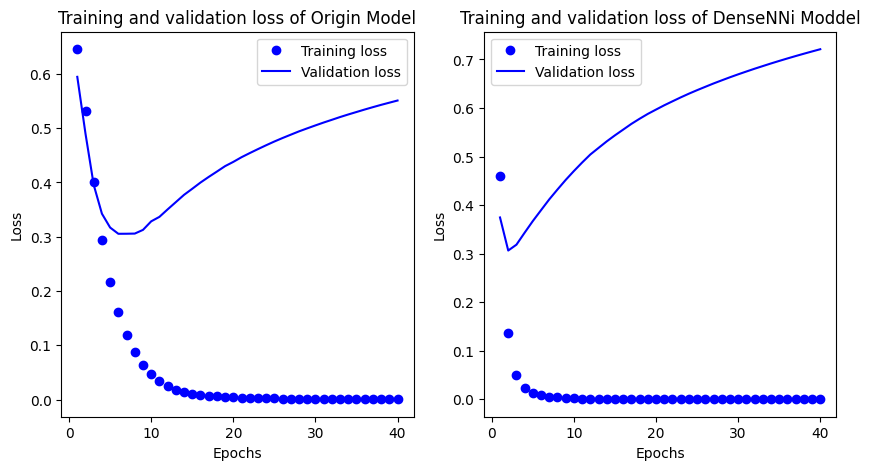

In [ ]:
# DenseNNi Model
DenseNNi_acc = DenseNNi_history_dict['accuracy']
DenseNNi_val_acc = DenseNNi_history_dict['val_accuracy']
DenseNNi_loss = DenseNNi_history_dict['loss']
DenseNNi_val_loss = DenseNNi_history_dict['val_loss']

epochs = range(1, len(DenseNNi_acc) + 1)

fig, ((ax5, ax6)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

# plot for Origin Model
# "bo" is for "blue dot"
ax5.plot(epochs, OriginNN_loss, 'bo', label='Training loss')
# b is for "solid blue line"
ax5.plot(epochs, OriginNN_val_loss, 'b', label='Validation loss')
ax5.title.set_text('Training and validation loss of Origin Model')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('Loss')
ax5.legend()

# Plot for DenseNNi Model
ax6.plot(epochs, DenseNNi_loss, 'bo', label='Training loss')
ax6.plot(epochs, DenseNNi_val_loss, 'b', label='Validation loss')
ax6.title.set_text('Training and validation loss of DenseNNi Moddel')
ax6.set_xlabel('Epochs')
ax6.set_ylabel('Loss')
ax6.legend()

plt.show()

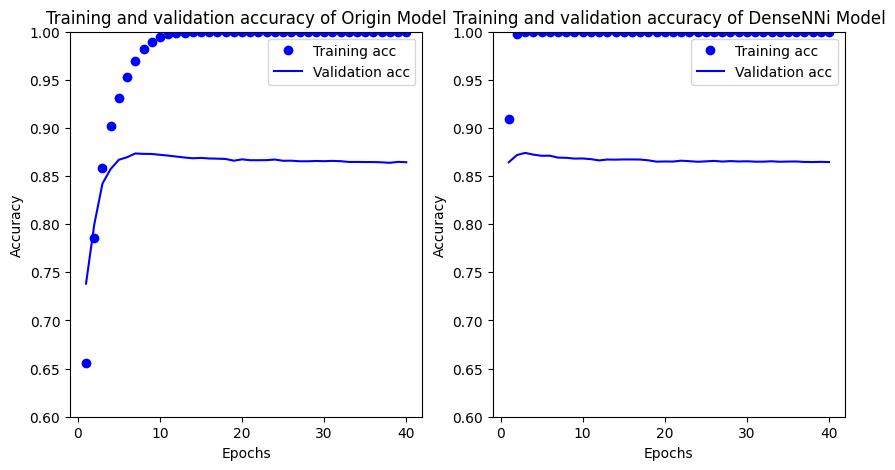

In [ ]:
fig, ((ax7, ax8)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

ax7.plot(epochs, OriginNN_acc, 'bo', label='Training acc')
ax7.plot(epochs, OriginNN_val_acc, 'b', label='Validation acc')
ax7.set_title('Training and validation accuracy of Origin Model')
ax7.set_xlabel('Epochs')
ax7.set_ylabel('Accuracy')
ax7.set_ylim(0.60, 1.00)
ax7.legend()

ax8.plot(epochs, DenseNNi_acc, 'bo', label='Training acc')
ax8.plot(epochs, DenseNNi_val_acc, 'b', label='Validation acc')
ax8.set_title('Training and validation accuracy of DenseNNi Model')
ax8.set_xlabel('Epochs')
ax8.set_ylabel('Accuracy')
ax8.set_ylim(0.60, 1.00)
ax8.legend()

plt.show()

#### Comment

The graphs indicate that from epoch 4, DenseNNi model reach 100% accuracy with trainning dataset while validation loss increases over time. In addition, the performance with test samples still remains the same as OrigNN model.

&#8594; It is clear that DenseNNi model has more hidden units (a higher-dimensional representation space), and/or more layers. This makes the network more computationally expensive and lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. Severe overfitting problem occurs. **The overfitting problem with DenseNNi is more obvious and severe than OrigNN model.**

### 3.4 Model 4 - DenseNNii
<a class="anchor" id="chapter_4_4"></a>

For this task, I'll add an L2 (kernel) regulariser to your hidden Dense layer.  Call this network DenseNNii. I'll train and evaluate this model and plot the graphs.Then, I compare the performance of DenseNNi with DenseNNii.

#### Build the DenseNNii model

In [ ]:
DenseNNii=tf.keras.Sequential()
DenseNNii.add(hub_layer)
DenseNNii.add(tf.keras.layers.Dense(50 + 10 * N, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
DenseNNii.add(tf.keras.layers.Dense(1))

DenseNNii.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_6 (Dense)             (None, 140)               7140      
                                                                 
 dense_7 (Dense)             (None, 1)                 141       
                                                                 
Total params: 48,197,881
Trainable params: 48,197,881
Non-trainable params: 0
_________________________________________________________________


#### Loss function and optimizer

In [ ]:
DenseNNii.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

#### Train the DenseNNii model

In [ ]:
# DenseNNii model
DenseNNii_history = DenseNNii.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 7s 198ms/step - loss: 1.0466 - accuracy: 0.9395 - val_loss: 0.9245 - val_accuracy: 0.8681
Epoch 2/40
30/30 [==============================] - 6s 202ms/step - loss: 0.6214 - accuracy: 0.9997 - val_loss: 0.7355 - val_accuracy: 0.8723
Epoch 3/40
30/30 [==============================] - 6s 189ms/step - loss: 0.4288 - accuracy: 0.9999 - val_loss: 0.6100 - val_accuracy: 0.8727
Epoch 4/40
30/30 [==============================] - 7s 230ms/step - loss: 0.3052 - accuracy: 0.9999 - val_loss: 0.5218 - val_accuracy: 0.8726
Epoch 5/40
30/30 [==============================] - 5s 155ms/step - loss: 0.2213 - accuracy: 0.9999 - val_loss: 0.4668 - val_accuracy: 0.8712
Epoch 6/40
30/30 [==============================] - 5s 171ms/step - loss: 0.1639 - accuracy: 0.9999 - val_loss: 0.4302 - val_accuracy: 0.8716
Epoch 7/40
30/30 [==============================] - 6s 189ms/step - loss: 0.1244 - accuracy: 1.0000 - val_loss: 0.4066 - val_accuracy: 0.8713
Epoch 

#### Evaluate the DenseNNii model

In [ ]:
DenseNNii_results = DenseNNii.evaluate(test_examples, test_labels)

print(DenseNNii_results)

782/782 [==============================] - 4s 6ms/step - loss: 0.4713 - accuracy: 0.8450
[0.47132042050361633, 0.8450000286102295]


#### Graph of accuracy and loss over time

model.fit() returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
DenseNNii_history_dict =DenseNNii_history.history

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

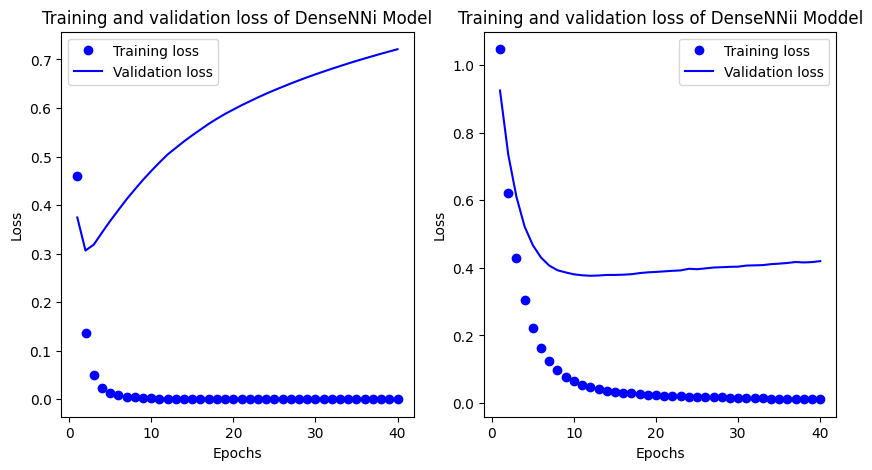

In [ ]:
# DenseNNii Model
DenseNNii_acc = DenseNNii_history_dict['accuracy']
DenseNNii_val_acc = DenseNNii_history_dict['val_accuracy']
DenseNNii_loss = DenseNNii_history_dict['loss']
DenseNNii_val_loss = DenseNNii_history_dict['val_loss']

epochs = range(1, len(DenseNNii_acc) + 1)

fig, ((ax9, ax10)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

# plot for Origin Model
# "bo" is for "blue dot"
ax9.plot(epochs, DenseNNi_loss, 'bo', label='Training loss')
# b is for "solid blue line"
ax9.plot(epochs, DenseNNi_val_loss, 'b', label='Validation loss')
ax9.title.set_text('Training and validation loss of DenseNNi Model')
ax9.set_xlabel('Epochs')
ax9.set_ylabel('Loss')
ax9.legend()

# Plot for DenseNNi Model
ax10.plot(epochs, DenseNNii_loss, 'bo', label='Training loss')
ax10.plot(epochs, DenseNNii_val_loss, 'b', label='Validation loss')
ax10.title.set_text('Training and validation loss of DenseNNii Moddel')
ax10.set_xlabel('Epochs')
ax10.set_ylabel('Loss')
ax10.legend()

plt.show()

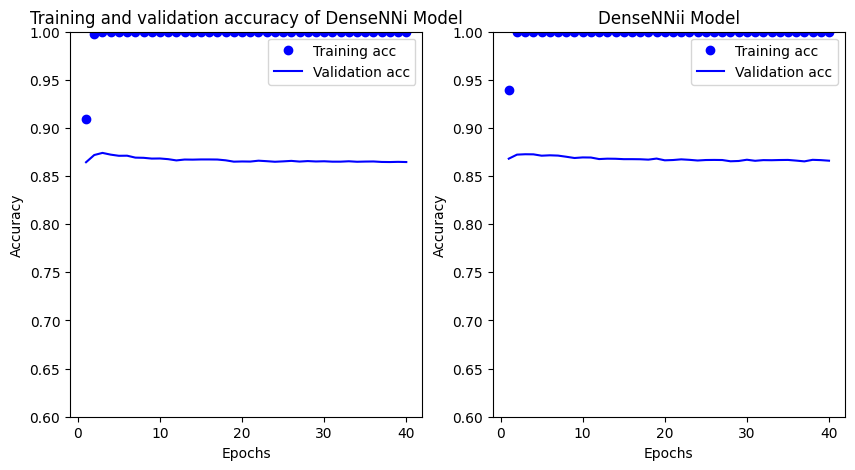

In [ ]:
fig, ((ax11, ax12)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

ax11.plot(epochs, DenseNNi_acc, 'bo', label='Training acc')
ax11.plot(epochs, DenseNNi_val_acc, 'b', label='Validation acc')
ax11.set_title('Training and validation accuracy of DenseNNi Model')
ax11.set_xlabel('Epochs')
ax11.set_ylabel('Accuracy')
ax11.set_ylim(0.60, 1.00)
ax11.legend()

ax12.plot(epochs, DenseNNii_acc, 'bo', label='Training acc')
ax12.plot(epochs, DenseNNii_val_acc, 'b', label='Validation acc')
ax12.set_title('DenseNNii Model')
ax12.set_xlabel('Epochs')
ax12.set_ylabel('Accuracy')
ax12.set_ylim(0.60, 1.00)
ax12.legend()

plt.show()

#### Comment

The epochs of DenseNNii model start with high accuracy for trainning dataset because of having many hidden units. Beside that, the validation loss are lower than DenseNNi model. The gap between train_loss and val_loss of DenseNNii is smaller in comparision with that of DenseNNi. While trainning and validation accuracy curve of DenseNNi look normal when they start at low and grow higher over time, DenseNNi provide the sign of overfitting when trainning accuracy start over 90% and reach 100% at 4th epoch.   

**Adding an L2 (kernel) regularizer to the hidden Dense layer of DenseNNii model can reduce overfitting which is the weakness of last model - DenseNNi.**

### 3.5 Model 5 - DenseNNiii
<a class="anchor" id="chapter_4_5"></a>

For this task, I'll add a second regularised Dense hidden layer in the neural net, of the same size as the Dense layer of Task 2 and inserted immediately following it.  Call this network DenseNNiii. I'll train and evaluate this model and plot the graphs.Then, I compare the performance of DenseNNiii with DenseNNii.

#### Build the DenseNNiii model

In [ ]:
DenseNNiii=tf.keras.Sequential()
DenseNNiii.add(hub_layer)
DenseNNiii.add(tf.keras.layers.Dense(50 + 10 * N, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
DenseNNiii.add(tf.keras.layers.Dense(50 + 10 * N, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
DenseNNiii.add(tf.keras.layers.Dense(1))

DenseNNiii.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_8 (Dense)             (None, 140)               7140      
                                                                 
 dense_9 (Dense)             (None, 140)               19740     
                                                                 
 dense_10 (Dense)            (None, 1)                 141       
                                                                 
Total params: 48,217,621
Trainable params: 48,217,621
Non-trainable params: 0
_________________________________________________________________


#### Loss function and optimizer

In [ ]:
DenseNNiii.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

#### Train the DenseNNiii model

In [ ]:
# DenseNNiii model
DenseNNiii_history = DenseNNiii.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 7s 198ms/step - loss: 2.0184 - accuracy: 0.9382 - val_loss: 1.7802 - val_accuracy: 0.8689
Epoch 2/40
30/30 [==============================] - 6s 215ms/step - loss: 1.2041 - accuracy: 1.0000 - val_loss: 1.2492 - val_accuracy: 0.8691
Epoch 3/40
30/30 [==============================] - 6s 190ms/step - loss: 0.7563 - accuracy: 1.0000 - val_loss: 0.9052 - val_accuracy: 0.8691
Epoch 4/40
30/30 [==============================] - 6s 195ms/step - loss: 0.4800 - accuracy: 1.0000 - val_loss: 0.7055 - val_accuracy: 0.8683
Epoch 5/40
30/30 [==============================] - 6s 182ms/step - loss: 0.3116 - accuracy: 1.0000 - val_loss: 0.5850 - val_accuracy: 0.8687
Epoch 6/40
30/30 [==============================] - 6s 188ms/step - loss: 0.2091 - accuracy: 1.0000 - val_loss: 0.5142 - val_accuracy: 0.8685
Epoch 7/40
30/30 [==============================] - 9s 291ms/step - loss: 0.1461 - accuracy: 1.0000 - val_loss: 0.4722 - val_accuracy: 0.8679
Epoch 

#### Evaluate the DenseNNi model

In [ ]:
DenseNNiii_results = DenseNNiii.evaluate(test_examples, test_labels)

print(DenseNNiii_results)

782/782 [==============================] - 4s 6ms/step - loss: 0.4908 - accuracy: 0.8442
[0.49076247215270996, 0.8442000150680542]


#### Graph of accuracy and loss over time

model.fit() returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
DenseNNiii_history_dict = DenseNNiii_history.history

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

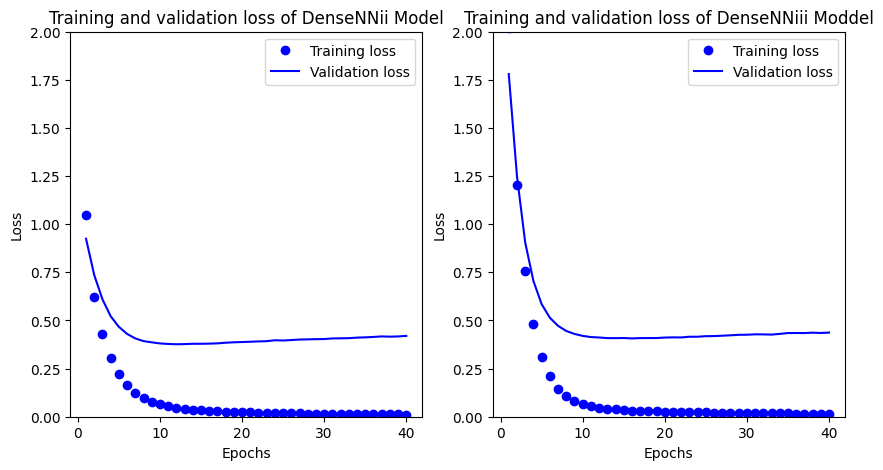

In [ ]:
# DenseNNii Model
DenseNNiii_acc = DenseNNiii_history_dict['accuracy']
DenseNNiii_val_acc = DenseNNiii_history_dict['val_accuracy']
DenseNNiii_loss = DenseNNiii_history_dict['loss']
DenseNNiii_val_loss = DenseNNiii_history_dict['val_loss']

epochs = range(1, len(DenseNNiii_acc) + 1)

fig, ((ax13, ax14)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

# plot for Origin Model
# "bo" is for "blue dot"
ax13.plot(epochs, DenseNNii_loss, 'bo', label='Training loss')
# b is for "solid blue line"
ax13.plot(epochs, DenseNNii_val_loss, 'b', label='Validation loss')
ax13.title.set_text('Training and validation loss of DenseNNii Model')
ax13.set_xlabel('Epochs')
ax13.set_ylabel('Loss')
ax13.set_ylim(0.00, 2.00)
ax13.legend()

# Plot for DenseNNi Model
ax14.plot(epochs, DenseNNiii_loss, 'bo', label='Training loss')
ax14.plot(epochs, DenseNNiii_val_loss, 'b', label='Validation loss')
ax14.title.set_text('Training and validation loss of DenseNNiii Moddel')
ax14.set_xlabel('Epochs')
ax14.set_ylabel('Loss')
ax14.set_ylim(0.00, 2.00)
ax14.legend()

plt.show()

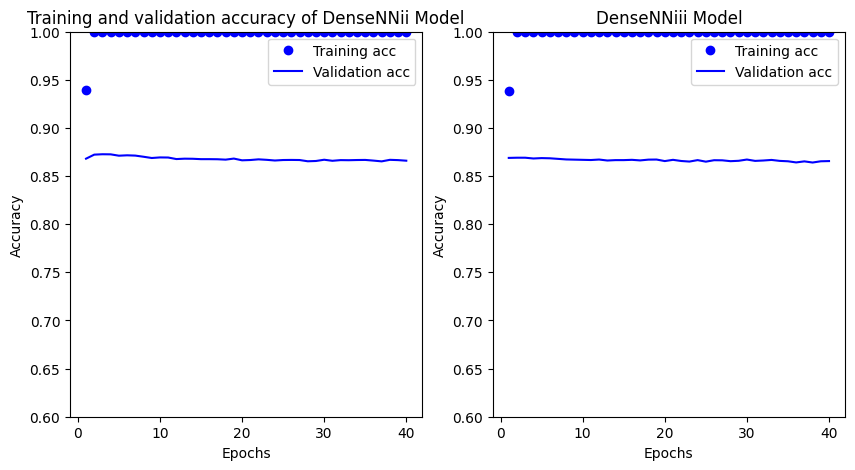

In [ ]:
fig, ((ax15, ax16)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

ax15.plot(epochs, DenseNNii_acc, 'bo', label='Training acc')
ax15.plot(epochs, DenseNNii_val_acc, 'b', label='Validation acc')
ax15.set_title('Training and validation accuracy of DenseNNii Model')
ax15.set_xlabel('Epochs')
ax15.set_ylabel('Accuracy')
ax15.set_ylim(0.60, 1.00)
ax15.legend()

ax16.plot(epochs, DenseNNiii_acc, 'bo', label='Training acc')
ax16.plot(epochs, DenseNNiii_val_acc, 'b', label='Validation acc')
ax16.set_title('DenseNNiii Model')
ax16.set_xlabel('Epochs')
ax16.set_ylabel('Accuracy')
ax16.set_ylim(0.60, 1.00)
ax16.legend()

plt.show()

#### Comment

- After adding second L2 (kernel) regularizer, there are significant differences in validation loss of DenseNNiii. Trainning and validation loss start around 2 at epoch 0  and then gradually drop until turining point. After turning point, the loss remain unchanged around 0.43. The gap between trainning and validation loss of DenseNNiii is likely same as those of DenseNNii.

- In regard of trainning and validation accuracy, the new model - DenseNNiii reachs high accuracy - 96% at first epoch. In conclusion, add second L2 (kernel) regularizer help controlling overfitting and improve the model performance. It can prevent the model from relying too heavily on specific features or patterns that may only be present in the training data.

### 3.6 Model 6 - DropNNi
<a class="anchor" id="chapter_4_6"></a>

For this task, I'll add a Dropout layer to DenseNNii (note: not to DenseNNiii), with dropout parameter 0.2, after your single hidden Dense layer.  Call this network DropNNi. I'll train and evaluate this model and plot the graphs.Then, I compare the performance of DropNNi with DenseNNii.

#### Build the DropNNi model

In [ ]:
DropNNi=tf.keras.Sequential()
DropNNi.add(hub_layer)
DropNNi.add(tf.keras.layers.Dense(50 + 10 * N, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
DropNNi.add(tf.keras.layers.Dropout(0.2))
DropNNi.add(tf.keras.layers.Dense(1))

DropNNi.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_11 (Dense)            (None, 140)               7140      
                                                                 
 dropout (Dropout)           (None, 140)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 141       
                                                                 
Total params: 48,197,881
Trainable params: 48,197,881
Non-trainable params: 0
_________________________________________________________________


#### Loss function and optimizer

In [ ]:
DropNNi.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

#### Train the DropNNi model

In [ ]:
# DropNNi model
DropNNi_history = DropNNi.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 7s 197ms/step - loss: 0.8558 - accuracy: 0.9640 - val_loss: 0.8964 - val_accuracy: 0.8657
Epoch 2/40
30/30 [==============================] - 6s 212ms/step - loss: 0.5453 - accuracy: 0.9999 - val_loss: 0.7615 - val_accuracy: 0.8668
Epoch 3/40
30/30 [==============================] - 5s 182ms/step - loss: 0.3977 - accuracy: 1.0000 - val_loss: 0.6515 - val_accuracy: 0.8678
Epoch 4/40
30/30 [==============================] - 6s 200ms/step - loss: 0.2928 - accuracy: 1.0000 - val_loss: 0.5734 - val_accuracy: 0.8672
Epoch 5/40
30/30 [==============================] - 5s 166ms/step - loss: 0.2181 - accuracy: 1.0000 - val_loss: 0.5206 - val_accuracy: 0.8674
Epoch 6/40
30/30 [==============================] - 6s 191ms/step - loss: 0.1644 - accuracy: 1.0000 - val_loss: 0.4827 - val_accuracy: 0.8673
Epoch 7/40
30/30 [==============================] - 5s 167ms/step - loss: 0.1255 - accuracy: 1.0000 - val_loss: 0.4587 - val_accuracy: 0.8668
Epoch 

#### Evaluate the DropNNi model

In [ ]:
DropNNi_results = DropNNi.evaluate(test_examples, test_labels)

print(DropNNi_results)

782/782 [==============================] - 4s 6ms/step - loss: 0.5144 - accuracy: 0.8452
[0.5144283175468445, 0.8452399969100952]


#### Graph of accuracy and loss over time

model.fit() returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
DropNNi_history_dict = DropNNi_history.history

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

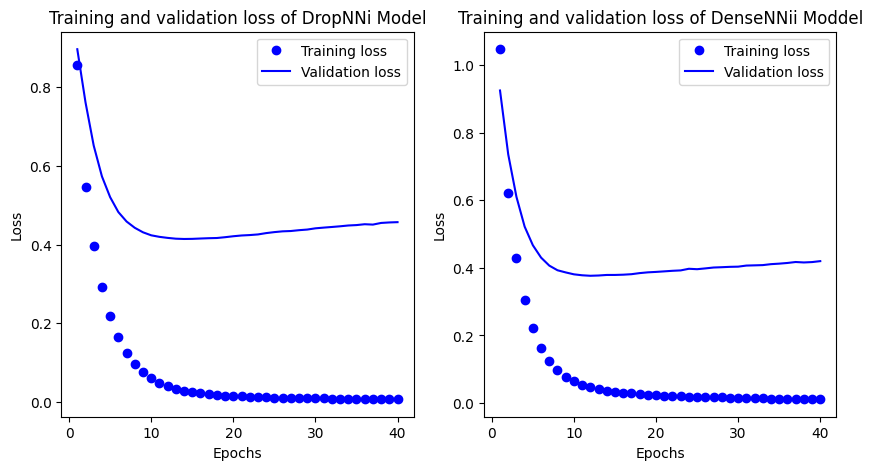

In [ ]:
# DenseNNii Model
DropNNi_acc = DropNNi_history_dict['accuracy']
DropNNi_val_acc = DropNNi_history_dict['val_accuracy']
DropNNi_loss = DropNNi_history_dict['loss']
DropNNi_val_loss = DropNNi_history_dict['val_loss']

epochs = range(1, len(DropNNi_acc) + 1)

fig, ((ax17, ax18)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

# plot for DropNNi Model
# "bo" is for "blue dot"
ax17.plot(epochs, DropNNi_loss, 'bo', label='Training loss')
# b is for "solid blue line"
ax17.plot(epochs, DropNNi_val_loss, 'b', label='Validation loss')
ax17.title.set_text('Training and validation loss of DropNNi Model')
ax17.set_xlabel('Epochs')
ax17.set_ylabel('Loss')
ax17.legend()

# Plot for DenseNNii Model
ax18.plot(epochs, DenseNNii_loss, 'bo', label='Training loss')
ax18.plot(epochs, DenseNNii_val_loss, 'b', label='Validation loss')
ax18.title.set_text('Training and validation loss of DenseNNii Moddel')
ax18.set_xlabel('Epochs')
ax18.set_ylabel('Loss')
ax18.legend()

plt.show()

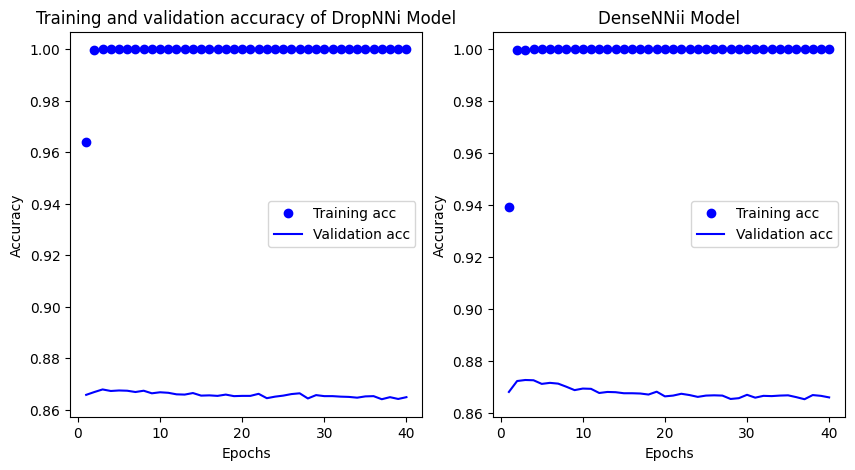

In [ ]:
fig, ((ax19, ax20)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

ax19.plot(epochs, DropNNi_acc, 'bo', label='Training acc')
ax19.plot(epochs, DropNNi_val_acc, 'b', label='Validation acc')
ax19.set_title('Training and validation accuracy of DropNNi Model')
ax19.set_xlabel('Epochs')
ax19.set_ylabel('Accuracy')
ax19.legend()

ax20.plot(epochs, DenseNNii_acc, 'bo', label='Training acc')
ax20.plot(epochs, DenseNNii_val_acc, 'b', label='Validation acc')
ax20.set_title('DenseNNii Model')
ax20.set_xlabel('Epochs')
ax20.set_ylabel('Accuracy')
ax20.legend()

plt.show()

#### Comment

- In comparision with DenseNNii model, DropNNi model has higher loss and val_loss from first epochs. The trainning loss and val loss graphs show that while val_loss of **DenseNNii model** mostly below 0.4 until the last epoch, al_loss of **DropNNii model** always above 0.4.

- In term of accuracy, both **DenseNNii model** and  **DropNNii model** start around 95% accuracy when working with tranning set at first epochs and reach 100% at the beginning. There is no clear differences in accuracy between two models.

The **DenseNNii model** seems to control overfitting better than **DropNNii model** when the gap between loss and val_loss is not big. The val_loss value of **DenseNNii model**  only increase slightly after turning point.


### 3.7 Model 7 - DropNNii
<a class="anchor" id="chapter_4_7"></a>

For this task, I'll take DropNNi and change the parameter to be (0.3 + 0.05 * N).  Call this network DropNNii. I'll train and evaluate this model and plot the graphs.Then, I compare the performance of DropNNi with DropNNii.

#### Build the DropNNii model

In [ ]:
DropNNii=tf.keras.Sequential()
DropNNii.add(hub_layer)
DropNNii.add(tf.keras.layers.Dense(50 + 10 * N, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
DropNNii.add(tf.keras.layers.Dropout(0.3 + 0.05 * N))
DropNNii.add(tf.keras.layers.Dense(1))

DropNNii.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_13 (Dense)            (None, 140)               7140      
                                                                 
 dropout_1 (Dropout)         (None, 140)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 141       
                                                                 
Total params: 48,197,881
Trainable params: 48,197,881
Non-trainable params: 0
_________________________________________________________________


#### Loss function and optimizer

In [ ]:
DropNNii.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

#### Train the DropNNii model

In [ ]:
# DropNNii model
DropNNii_history = DropNNii.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 7s 210ms/step - loss: 0.9795 - accuracy: 0.8748 - val_loss: 0.9131 - val_accuracy: 0.8667
Epoch 2/40
30/30 [==============================] - 6s 210ms/step - loss: 0.5739 - accuracy: 0.9968 - val_loss: 0.7906 - val_accuracy: 0.8676
Epoch 3/40
30/30 [==============================] - 6s 188ms/step - loss: 0.4235 - accuracy: 0.9985 - val_loss: 0.6874 - val_accuracy: 0.8670
Epoch 4/40
30/30 [==============================] - 6s 218ms/step - loss: 0.3180 - accuracy: 0.9993 - val_loss: 0.6136 - val_accuracy: 0.8673
Epoch 5/40
30/30 [==============================] - 6s 194ms/step - loss: 0.2413 - accuracy: 0.9997 - val_loss: 0.5673 - val_accuracy: 0.8673
Epoch 6/40
30/30 [==============================] - 6s 205ms/step - loss: 0.1847 - accuracy: 0.9998 - val_loss: 0.5329 - val_accuracy: 0.8660
Epoch 7/40
30/30 [==============================] - 5s 159ms/step - loss: 0.1440 - accuracy: 0.9998 - val_loss: 0.5081 - val_accuracy: 0.8666
Epoch 

#### Evaluate the DropNNii model

In [ ]:
DropNNii_results = DropNNii.evaluate(test_examples, test_labels)

print(DropNNii_results)

782/782 [==============================] - 4s 5ms/step - loss: 0.5820 - accuracy: 0.8461
[0.5819534659385681, 0.8460800051689148]


#### Graph of accuracy and loss over time

model.fit() returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
DropNNii_history_dict = DropNNii_history.history

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

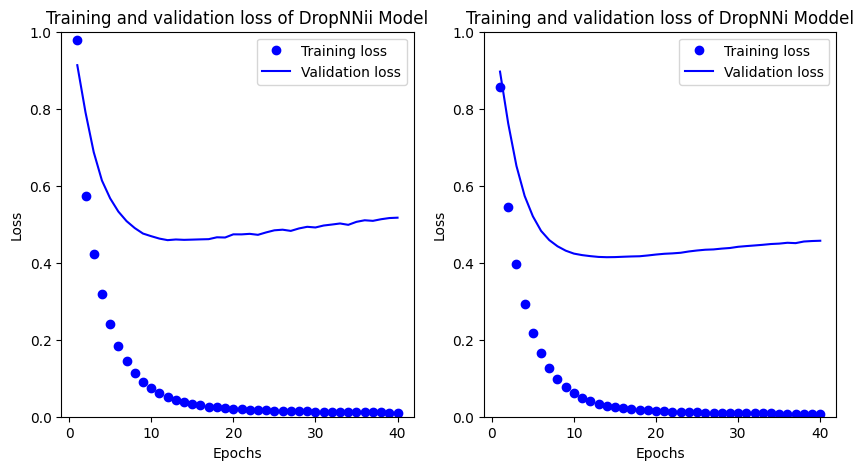

In [ ]:
# DropNNii Model
DropNNii_acc = DropNNii_history_dict['accuracy']
DropNNii_val_acc = DropNNii_history_dict['val_accuracy']
DropNNii_loss = DropNNii_history_dict['loss']
DropNNii_val_loss = DropNNii_history_dict['val_loss']

epochs = range(1, len(DropNNii_acc) + 1)

fig, ((ax21, ax22)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

# plot for Origin Model
# "bo" is for "blue dot"
ax21.plot(epochs, DropNNii_loss, 'bo', label='Training loss')
# b is for "solid blue line"
ax21.plot(epochs, DropNNii_val_loss, 'b', label='Validation loss')
ax21.title.set_text('Training and validation loss of DropNNii Model')
ax21.set_xlabel('Epochs')
ax21.set_ylabel('Loss')
ax21.set_ylim(0.00, 1.00)
ax21.legend()

# Plot for DenseNNi Model
ax22.plot(epochs, DropNNi_loss, 'bo', label='Training loss')
ax22.plot(epochs, DropNNi_val_loss, 'b', label='Validation loss')
ax22.title.set_text('Training and validation loss of DropNNi Moddel')
ax22.set_xlabel('Epochs')
ax22.set_ylabel('Loss')
ax22.set_ylim(0.00, 1.00)
ax22.legend()

plt.show()

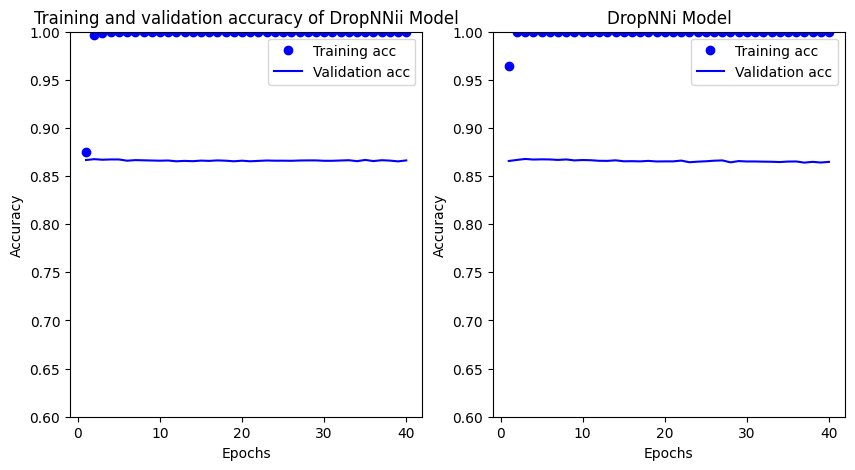

In [ ]:
fig, ((ax21, ax22)) = plt.subplots(nrows = 1,
                                 ncols = 2,
                                 figsize = (10,5))

ax21.plot(epochs, DropNNii_acc, 'bo', label='Training acc')
ax21.plot(epochs, DropNNii_val_acc, 'b', label='Validation acc')
ax21.set_title('Training and validation accuracy of DropNNii Model')
ax21.set_xlabel('Epochs')
ax21.set_ylabel('Accuracy')
ax21.set_ylim(0.60, 1.00)
ax21.legend()

ax22.plot(epochs, DropNNi_acc, 'bo', label='Training acc')
ax22.plot(epochs, DropNNi_val_acc, 'b', label='Validation acc')
ax22.set_title('DropNNi Model')
ax22.set_xlabel('Epochs')
ax22.set_ylabel('Accuracy')
ax22.set_ylim(0.60, 1.00)
ax22.legend()

plt.show()

#### Comment

- Increasing the dropout rate make **DropNNii model** becomes less likely to rely on specific features or patterns in the training data which can help prevent overfitting. The evidence is that the model get trainning accuracy at 87% and this value increase overtime. The loss and val_loss are around 1 at first epoch and reach the best value at 0.45 at epoch 13.

- In comparison with **DropNNi model** , the **DropNNii** performance is likely to be slightly worse than **DropNNi model** in regard of loss and val_loss. Therefore, **dropout rate** at 0.2 seems to work more productive.

- About the accuracy, there is no clear difference between two models except for that while **DropNNii model** starts at 87% accuracy for trainning set, **DropNNi model** begins with 96%. The val_acc are the same.


### 4. Best Model & Sentiment Prediction
<a class="anchor" id="chapter_5"></a>

After evaluating seven different model architectures, the second model — referred to as the **Scratch Model** — was selected as the best-performing one based on its overall accuracy and consistency.

#### 4.1 Clone the Scratch Model
<a class="anchor" id="chapter_5_1"></a>

In [ ]:
NNBest = tf.keras.models.clone_model(SratchNN)
NNBest.set_weights(SratchNN.get_weights())

In [ ]:
NNBest.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 50)           5000000   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,000,833
Trainable params: 5,000,833
No

In [ ]:
NNBest.compile(optimizer='adam',
                 loss=tf.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

#### 4.2 Predict the test set
<a class="anchor" id="chapter_5_2"></a>

In [ ]:
# Generate predictions for the reviews
prediction = NNBest.predict(test_examples)

782/782 [==============================] - 3s 4ms/step


In [ ]:
# Sort the reviews based on the predicted sentiment scores
sorted_reviews = sorted(zip(test_examples, prediction), key=lambda x: x[1], reverse=True)

#### 4.3 Top 5 most positive reviews
<a class="anchor" id="chapter_5_3"></a>

In [ ]:
for i in range(5) :
  # Select the most positive and negative reviews
  most_positive_review = sorted_reviews[i]

  # Print and analyze the selected reviews
  print(f"Top {i+1} Positive Review:")
  print(most_positive_review[0])
  print("Sentiment Score:", most_positive_review[1])
  print()

Top 1 Positive Review:
b"This is one of Bruce's most underrated films in my opinion, its an awesome heartwarming film, with a neat story and an amazing performance from Bruce Willis!. All the characters are great, and I thought Willis and Spencer Breslin were just awesome together, plus Bruce Willis is simply amazing in this!. This is definitely one of Bruce's best comedic performances (The waaaaaaaaaamabulance thing was great) and I thought it was very well written and made as well, plus The finale is especially cool!. It's good natured and it was cool how you can see Russell's (Willis) character change throughout the film! plus the ending was pretty good. I think this should be higher then 6.0 and it's one of the best Disney films I have ever seen! plus it has many surprising moments throughout. All the characters are extremely likable, and it also has a cute love story angle too it as well, plus Bruce and Spencer Breslin both had some really funny lines (Holy Smokes!). This is one o

#### 4.4 Top 5 negative reviews
<a class="anchor" id="chapter_5_4"></a>

In [ ]:
for i in range(5) :
  # Select the most positive and negative reviews
  most_negative_review = sorted_reviews[-(i+1)]

  # Print and analyze the selected reviews
  print(f"Top {(i+1)} Negative Review:")
  print(most_negative_review[0])
  print("Sentiment Score:", most_negative_review[1])
  print()

Top 1 Negative Review:
b'Hollywood has churned out yet another garbage that\'s wildly overhyped and underwhelming on a first-time viewing basis. Hannibal is bad, terrible, inept, lame, droll, idiotic, contrived, laughable and utterly atrocious (no pun intended). Minor spoilers follow...<br /><br />This movie has huge logic holes - more than any Bruckheimer/Bay movie - or for that matter - any movie that exemplify the indulgence of Hollywood exaggeration. It\'s a slick Hollywood production designed to cash in on Hannibal Lector mania, directed by "so-somber-he-takes-this-way-too-seriously" hack director Ridley Scott and produced by a hack Italian producer with an inflated ego whose credo is "doesn\'t matter whether film is s**t, money is good".<br /><br />I can\'t get over the fact that acclaimed screenwriters David Mamet and Steven Zaillian wrote this tripe adapted from a lame and pretentious book by a good-novelist-turned-hack-author Thomas Harris. David and Steven - well-known and im

The model performed well by accurately predicting the sentiment of all the sample reviews, correctly identifying both positive and negative cases.

#### 4.5 The best model with Dropout layer
<a class="anchor" id="chapter_5_5"></a>

In [ ]:
NNBestDrop = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(max_features, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1)])

NNBestDrop.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 250, 50)           5000000   
                                                                 
 global_average_pooling1d_2   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 16)                816       
                                                                 
 dropout_5 (Dropout)         (None, 16)               

In [ ]:
NNBestDrop.compile(optimizer='adam',
                 loss=tf.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
NNBestDrop_history = NNBestDrop.fit(partial_x_train,
                       partial_y_train,
                       epochs=40,
                       batch_size=512,
                       validation_data=(x_val, y_val),
                       verbose=1)

Epoch 1/40
30/30 [==============================] - 8s 240ms/step - loss: 0.6913 - accuracy: 0.5900 - val_loss: 0.6881 - val_accuracy: 0.7026
Epoch 2/40
30/30 [==============================] - 6s 189ms/step - loss: 0.6817 - accuracy: 0.6975 - val_loss: 0.6730 - val_accuracy: 0.7503
Epoch 3/40
30/30 [==============================] - 6s 213ms/step - loss: 0.6587 - accuracy: 0.7507 - val_loss: 0.6422 - val_accuracy: 0.7774
Epoch 4/40
30/30 [==============================] - 6s 192ms/step - loss: 0.6169 - accuracy: 0.7864 - val_loss: 0.5937 - val_accuracy: 0.8031
Epoch 5/40
30/30 [==============================] - 7s 232ms/step - loss: 0.5571 - accuracy: 0.8133 - val_loss: 0.5357 - val_accuracy: 0.8223
Epoch 6/40
30/30 [==============================] - 5s 171ms/step - loss: 0.4913 - accuracy: 0.8365 - val_loss: 0.4770 - val_accuracy: 0.8378
Epoch 7/40
30/30 [==============================] - 5s 169ms/step - loss: 0.4273 - accuracy: 0.8611 - val_loss: 0.4281 - val_accuracy: 0.8505
Epoch 

In [ ]:
# Evaluate with test dataset
NNBestDrop_results = NNBestDrop.evaluate(test_examples, test_labels)

print(NNBestDrop_results)

782/782 [==============================] - 4s 5ms/step - loss: 0.4625 - accuracy: 0.8563
[0.4624897539615631, 0.8563200235366821]


In [ ]:
# Get the predictions for NNBestDrop
predictions_NNBestDrop = NNBestDrop.predict(test_examples)

782/782 [==============================] - 3s 4ms/step


In [ ]:

for i in range(100+20*N,120+20*N+1):
  review = test_examples[i]
  print(f"Review {i} : \n {test_examples[i]}")
  print("NNBest Sentiment Score:", prediction[i])
  print("NNBestDrop Sentiment Score:", predictions_NNBestDrop[i])
  print("Test label for this review : ", test_labels[i])
  print()

Review 280 : 
 b"*spoiler alert!* it just gets to me the nerve some people have to remake (and i use the term loosely here..) good movies. in the american version of this dutch thriller, someone decided the original ending wasn't pasteurized enough for american audiences. so what do they do? they create a new one! a stupid, improbable, i-pretend-i'm-dead-but-come-to-life-again-so-the-good-guy-can-kick-my-butt- some-more kind of ending. do yourself a favor and get the original one."
NNBest Sentiment Score: [-2.620389]
NNBestDrop Sentiment Score: [-2.8376644]
Test label for this review :  0

Review 281 : 
 b'This guy is a real piece of work. An angry, immature boy in a grown man\'s body, packing all the charisma of a rock, he goes around to places most people would only wish to visit and does his best to be as miserable as possible.<br /><br />Give this job to someone else who actually appreciates it.<br /><br />I could go down an endless list of all the stupid things this guy does in hi

#### 4.6 Comment
<a class="anchor" id="chapter_5_6"></a>

* Based on reviews 280 to 300, the **NNBest model** demonstrated higher accuracy in predicting sentiment compared to the **NNBestDrop model**.

* In Review 292, where the sentiment is ambiguous, **NNBest** predicted a negative sentiment with a score of -0.308, while **NNBestDrop** predicted a positive sentiment with a score of 0.385.

Although **NNBest** provided the correct prediction, both models produced low confidence scores — which appropriately reflect the uncertainty in the text.


----------------------------------------------------------------------------------------------

### 5. Conclusion
<a class="anchor" id="chapter_6"></a>

This project successfully built and compared seven different neural network architectures to classify movie reviews by sentiment using the IMDB dataset. After evaluating all models, the **Scratch Model (NNBest)** demonstrated the most consistent and accurate performance on the test data.

In particular, when analyzing edge cases such as Review 292—where the sentiment was ambiguous— **NNBest** correctly predicted the negative sentiment, while the alternative model (**NNBestDrop**) misclassified it as positive. The low confidence scores from both models in such cases further reflected the uncertainty in the text, which is a desirable behavior in real-world applications.

Overall, the selected model achieved strong performance in identifying both clear and borderline sentiments, making it a solid foundation for real-world sentiment classification tasks.